# Khmer Space Injector — Model Evaluation & Overfitting Check

This notebook:
1. Loads your **best checkpoint** (highest score model).
2. Evaluates it on a **validation split** (and optional test split).
3. Retrains the model with the same hyperparameters while tracking **train vs val loss** to detect overfitting.
4. Plots metrics: **loss curves, token accuracy, precision/recall/F1 (boundary class), confusion matrix**, and optional PR/ROC curves.

In [1]:
# --- Imports & path setup ---
import os
import json
from dataclasses import dataclass
from typing import Dict

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Project imports
from src.net import KhmerRNN
from src.dataloader import load_data, create_dataloader
from src.utils import decode_spaces, select_device, set_seed

# Optional (for nicer reports/curves). If not installed, notebook still works.
try:
    from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, auc
    SKLEARN_OK = True
except Exception:
    SKLEARN_OK = False

print("sklearn available:", SKLEARN_OK)

c:\Users\limse\miniconda3\envs\khmer-space-injector\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


sklearn available: True


In [2]:
# --- Experiment config (match your training command) ---
@dataclass
class CFG:
    # data
    train_path: str = "data"
    max_length: int = 128
    num_workers: int = 0

    # split
    seed: int = 42
    val_ratio: float = 0.10
    test_ratio: float = 0.00  # set >0 if you want a test split too

    # training hyperparams (same as your command)
    device: str = "cuda"
    batch_size: int = 128
    epochs: int = 20
    optimizer: str = "adamw"
    lr: float = 0.01
    weight_decay: float = 0.0
    grad_clip: float = 5.0

    # model
    rnn_type: str = "lstm"
    embedding_dim: int = 128
    hidden_dim: int = 256
    num_layers: int = 2
    dropout: float = 0.3
    bidirectional: bool = True
    residual: bool = False

    # paths
    ckpt_path: str = "checkpoints/khmer_rnn_model3.pt"      # best checkpoint you want to evaluate
    vocab_path: str = "checkpoints/vocab_model3.json"      # vocab saved during training (optional)
    retrain_ckpt_out: str = "checkpoints/retrain_best_model3.pt"
    retrain_log_json: str = "checkpoints/retrain_history_model3.json"

In [3]:
cfg = CFG()

set_seed(cfg.seed)
device = select_device(cfg.device)
device

device(type='cuda')

In [4]:
# --- Load dataset as raw texts+labels then split ---
# load_data(..., batch_size=None) returns (texts, labels, char_to_index)
texts, labels, vocab = load_data(
    data_dir=cfg.train_path,
    batch_size=None,
    max_length=cfg.max_length,
    char_to_index=None,
    shuffle=True,
    num_workers=cfg.num_workers,
    skip_invalid=True,
    return_vocab=False,
)

print("Total samples:", len(texts))
print("Vocab size:", len(vocab))

# Shuffle indices reproducibly
idx = np.arange(len(texts))
rng = np.random.default_rng(cfg.seed)
rng.shuffle(idx)

n_total = len(idx)
n_test = int(round(cfg.test_ratio * n_total))
n_val  = int(round(cfg.val_ratio * n_total))
n_train = n_total - n_val - n_test

train_idx = idx[:n_train]
val_idx   = idx[n_train:n_train+n_val]
test_idx  = idx[n_train+n_val:]

def take_split(idxs):
    return [texts[i] for i in idxs], [labels[i] for i in idxs]

train_texts, train_labels = take_split(train_idx)
val_texts, val_labels     = take_split(val_idx)
test_texts, test_labels   = take_split(test_idx) if n_test > 0 else ([], [])

print(f"Split sizes -> train={len(train_texts)} val={len(val_texts)} test={len(test_texts)}")


[INFO] Skipped 5449 invalid lines
Total samples: 4288
Vocab size: 199
Split sizes -> train=3859 val=429 test=0


In [5]:
# --- Build DataLoaders ---
train_loader, _ = create_dataloader(
    train_texts, train_labels, vocab,
    batch_size=cfg.batch_size,
    max_length=cfg.max_length,
    shuffle=True,
    num_workers=cfg.num_workers,
)

val_loader, _ = create_dataloader(
    val_texts, val_labels, vocab,
    batch_size=cfg.batch_size,
    max_length=cfg.max_length,
    shuffle=False,
    num_workers=cfg.num_workers,
)

test_loader = None
if len(test_texts) > 0:
    test_loader, _ = create_dataloader(
        test_texts, test_labels, vocab,
        batch_size=cfg.batch_size,
        max_length=cfg.max_length,
        shuffle=False,
        num_workers=cfg.num_workers,
    )

len(train_loader), len(val_loader), (len(test_loader) if test_loader else 0)


(31, 4, 0)

In [7]:
# --- Build model and load BEST checkpoint (highest score model) ---
model = KhmerRNN(
    vocab_size=len(vocab),
    embedding_dim=cfg.embedding_dim,
    hidden_dim=cfg.hidden_dim,
    num_layers=cfg.num_layers,
    dropout=cfg.dropout,
    bidirectional=cfg.bidirectional,
    rnn_type=cfg.rnn_type,
    residual=cfg.residual,
    use_crf=False,
).to(device)


if os.path.isfile(cfg.ckpt_path):
    model.load_state_dict(torch.load(cfg.ckpt_path, map_location=device))
else:
    print("No checkpoint found — training required before evaluation.")

model.eval()

# Parameter counts
n_params = sum(p.numel() for p in model.parameters())
n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Loaded ckpt: {cfg.ckpt_path}")
print(f"params_total={n_params:,} trainable={n_trainable:,}")


No checkpoint found — training required before evaluation.
Loaded ckpt: checkpoints/khmer_rnn_model3.pt
params_total=2,389,890 trainable=2,389,890


In [ ]:
# --- Evaluation utilities ---
IGNORE_INDEX = -100

@torch.no_grad()
def eval_epoch(model: nn.Module, loader, criterion: nn.Module) -> dict:
    model.eval()
    total_loss = 0.0
    total_tokens = 0

    # For classification metrics on boundary label (0/1)
    all_true = []
    all_pred = []
    all_prob = []  # prob of class 1

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)  # (B,T) with -100 padding

        logits = model(x)  # (B,T,2)
        loss = criterion(logits.view(-1, 2), y.view(-1))

        # valid positions
        mask = (y != IGNORE_INDEX)
        if mask.any():
            probs1 = torch.softmax(logits, dim=-1)[..., 1]
            pred = logits.argmax(dim=-1)

            y_valid = y[mask].detach().cpu().numpy().astype(int)
            p_valid = pred[mask].detach().cpu().numpy().astype(int)
            s_valid = probs1[mask].detach().cpu().numpy().astype(float)

            all_true.append(y_valid)
            all_pred.append(p_valid)
            all_prob.append(s_valid)

            total_tokens += int(mask.sum().item())

        total_loss += float(loss.item())

    mean_loss = total_loss / max(1, len(loader))

    if total_tokens == 0:
        return {
            "loss": mean_loss,
            "token_acc": 0.0,
            "precision_1": 0.0,
            "recall_1": 0.0,
            "f1_1": 0.0,
            "confusion": np.zeros((2, 2), dtype=int),
            "y_true": np.array([], dtype=int),
            "y_pred": np.array([], dtype=int),
            "y_prob": np.array([], dtype=float),
        }

    y_true = np.concatenate(all_true)
    y_pred = np.concatenate(all_pred)
    y_prob = np.concatenate(all_prob)

    token_acc = float((y_true == y_pred).mean())

    # Confusion matrix (manual, safe without sklearn)
    conf = np.zeros((2, 2), dtype=int)
    for t, p in zip(y_true, y_pred):
        if t in (0, 1) and p in (0, 1):
            conf[t, p] += 1

    # Precision/Recall/F1 for class 1 (space boundary)
    tp = conf[1, 1]
    fp = conf[0, 1]
    fn = conf[1, 0]
    precision_1 = tp / (tp + fp + 1e-12)
    recall_1 = tp / (tp + fn + 1e-12)
    f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1 + 1e-12)

    return {
        "loss": mean_loss,
        "token_acc": token_acc,
        "precision_1": float(precision_1),
        "recall_1": float(recall_1),
        "f1_1": float(f1_1),
        "confusion": conf,
        "y_true": y_true,
        "y_pred": y_pred,
        "y_prob": y_prob,
    }


def plot_confusion_matrix(conf: np.ndarray, title: str = "Confusion matrix") -> None:
    fig = plt.figure()
    plt.imshow(conf)  # default colormap
    plt.title(title)
    plt.xlabel("Pred")
    plt.ylabel("True")
    for (i, j), v in np.ndenumerate(conf):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.xticks([0, 1], ["0", "1"])
    plt.yticks([0, 1], ["0", "1"])
    plt.show()


def plot_loss_curves(history: dict) -> None:
    fig = plt.figure()
    plt.plot(history["train_loss"], label="train_loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Train vs Val Loss")
    plt.legend()
    plt.show()


VAL metrics:
  loss: 0.707953
  token_acc: 0.212532
  precision_1: 0.212532
  recall_1: 1.000000
  f1_1: 0.350559


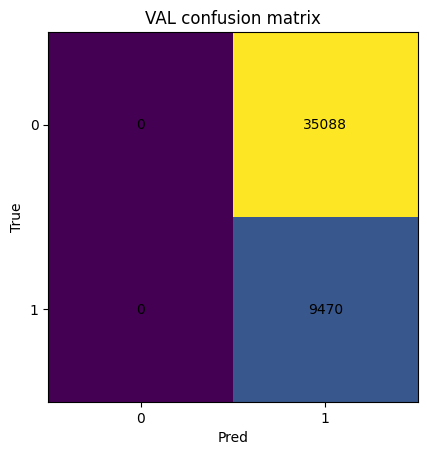


Classification report (VAL):
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000     35088
           1     0.2125    1.0000    0.3506      9470

    accuracy                         0.2125     44558
   macro avg     0.1063    0.5000    0.1753     44558
weighted avg     0.0452    0.2125    0.0745     44558



c:\Users\limse\miniconda3\envs\khmer-space-injector\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\limse\miniconda3\envs\khmer-space-injector\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\limse\miniconda3\envs\khmer-space-injector\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

In [9]:
# --- Evaluate your BEST checkpoint on VAL (and TEST if enabled) ---
criterion = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)

val_metrics = eval_epoch(model, val_loader, criterion)
print("VAL metrics:")
for k in ["loss", "token_acc", "precision_1", "recall_1", "f1_1"]:
    print(f"  {k}: {val_metrics[k]:.6f}")

plot_confusion_matrix(val_metrics["confusion"], title="VAL confusion matrix")

if SKLEARN_OK and val_metrics["y_true"].size > 0:
    print("\nClassification report (VAL):")
    print(classification_report(val_metrics["y_true"], val_metrics["y_pred"], digits=4))

if test_loader is not None:
    test_metrics = eval_epoch(model, test_loader, criterion)
    print("\nTEST metrics:")
    for k in ["loss", "token_acc", "precision_1", "recall_1", "f1_1"]:
        print(f"  {k}: {test_metrics[k]:.6f}")
    plot_confusion_matrix(test_metrics["confusion"], title="TEST confusion matrix")


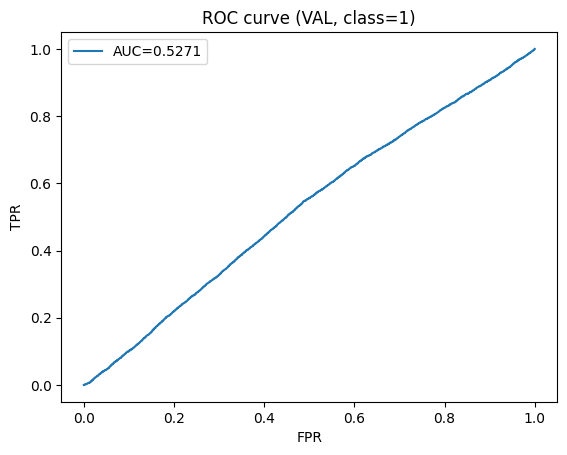

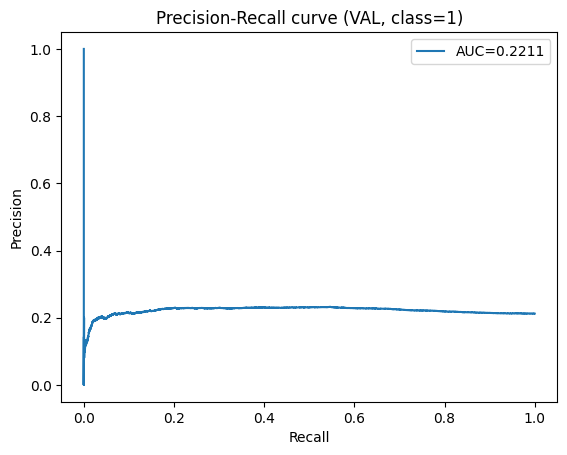

In [10]:
# --- Optional: PR / ROC curves for class=1 (boundary) ---
# Only if sklearn is available and there are valid labels
if not SKLEARN_OK:
    print("sklearn not available. Skipping PR/ROC.")
elif val_metrics["y_true"].size == 0:
    print("No valid labels. Skipping PR/ROC.")
else:
    y_true = val_metrics["y_true"]
    y_prob = val_metrics["y_prob"]

    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    fig = plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={roc_auc:.4f}")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC curve (VAL, class=1)")
    plt.legend()
    plt.show()

    # PR
    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(rec, prec)

    fig = plt.figure()
    plt.plot(rec, prec, label=f"AUC={pr_auc:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall curve (VAL, class=1)")
    plt.legend()
    plt.show()


epoch=01 train_loss=0.5015 train_acc=0.8484 val_loss=0.3396 val_acc=0.8479 val_f1_1=0.5807
epoch=02 train_loss=0.2669 train_acc=0.9179 val_loss=0.1907 val_acc=0.9173 val_f1_1=0.8148
epoch=03 train_loss=0.1614 train_acc=0.9520 val_loss=0.1205 val_acc=0.9500 val_f1_1=0.8863
epoch=04 train_loss=0.1123 train_acc=0.9668 val_loss=0.0886 val_acc=0.9640 val_f1_1=0.9178
epoch=05 train_loss=0.0889 train_acc=0.9751 val_loss=0.0724 val_acc=0.9728 val_f1_1=0.9358
epoch=06 train_loss=0.0737 train_acc=0.9802 val_loss=0.0601 val_acc=0.9772 val_f1_1=0.9469
epoch=07 train_loss=0.0626 train_acc=0.9839 val_loss=0.0530 val_acc=0.9803 val_f1_1=0.9539
epoch=08 train_loss=0.0544 train_acc=0.9866 val_loss=0.0486 val_acc=0.9832 val_f1_1=0.9602
epoch=09 train_loss=0.0473 train_acc=0.9891 val_loss=0.0433 val_acc=0.9852 val_f1_1=0.9650
epoch=10 train_loss=0.0415 train_acc=0.9910 val_loss=0.0395 val_acc=0.9864 val_f1_1=0.9680
epoch=11 train_loss=0.0389 train_acc=0.9913 val_loss=0.0388 val_acc=0.9867 val_f1_1=0.9686

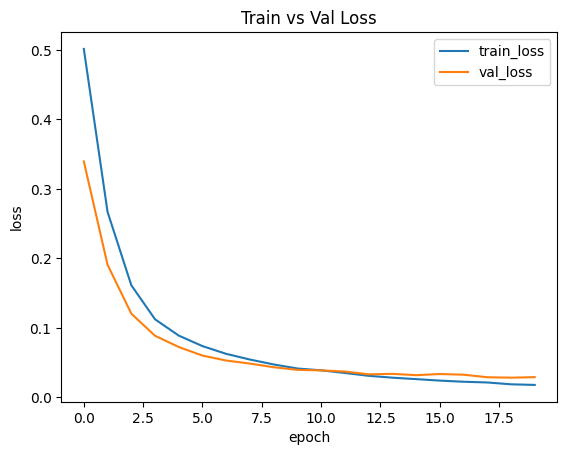

Saved best retrain ckpt: checkpoints/retrain_best_model3.pt
Saved history: checkpoints/retrain_history_model3.json


In [11]:
# --- Retrain to check overfitting (track train vs val loss) ---
# This trains from scratch with your hyperparameters and saves best-by-val-loss checkpoint.

def make_model() -> nn.Module:
    return KhmerRNN(
        vocab_size=len(vocab),
        embedding_dim=cfg.embedding_dim,
        hidden_dim=cfg.hidden_dim,
        num_layers=cfg.num_layers,
        dropout=cfg.dropout,
        bidirectional=cfg.bidirectional,
        rnn_type=cfg.rnn_type,
        residual=cfg.residual,
        use_crf=False,
    ).to(device)

def make_optimizer(model: nn.Module):
    name = cfg.optimizer.lower()
    if name == "adamw":
        return torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    if name == "adam":
        return torch.optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    if name == "sgd":
        return torch.optim.SGD(model.parameters(), lr=cfg.lr, momentum=0.9, weight_decay=cfg.weight_decay)
    raise ValueError(f"Unknown optimizer: {cfg.optimizer}")

def train_one_run() -> dict:
    model = make_model()
    opt = make_optimizer(model)
    crit = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_token_acc": [],
        "val_token_acc": [],
        "val_f1_1": [],
    }

    best_val = float("inf")

    for epoch in range(1, cfg.epochs + 1):
        model.train()
        total = 0.0
        n_batches = 0

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            opt.zero_grad(set_to_none=True)
            logits = model(x)
            loss = crit(logits.view(-1, 2), y.view(-1))
            loss.backward()

            if cfg.grad_clip and cfg.grad_clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)

            opt.step()
            total += float(loss.item())
            n_batches += 1

        train_loss = total / max(1, n_batches)
        train_metrics = eval_epoch(model, train_loader, crit)  # includes token acc
        val_metrics = eval_epoch(model, val_loader, crit)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_metrics["loss"])
        history["train_token_acc"].append(train_metrics["token_acc"])
        history["val_token_acc"].append(val_metrics["token_acc"])
        history["val_f1_1"].append(val_metrics["f1_1"])

        print(
            f"epoch={epoch:02d} "
            f"train_loss={train_loss:.4f} train_acc={train_metrics['token_acc']:.4f} "
            f"val_loss={val_metrics['loss']:.4f} val_acc={val_metrics['token_acc']:.4f} val_f1_1={val_metrics['f1_1']:.4f}"
        )

        # Save best
        if val_metrics["loss"] < best_val:
            best_val = val_metrics["loss"]
            os.makedirs(os.path.dirname(cfg.retrain_ckpt_out) or '.', exist_ok=True)
            torch.save(model.state_dict(), cfg.retrain_ckpt_out)

    # Save history
    os.makedirs(os.path.dirname(cfg.retrain_log_json) or '.', exist_ok=True)
    with open(cfg.retrain_log_json, "w", encoding="utf-8") as f:
        json.dump(history, f, indent=2)

    return history

history = train_one_run()
plot_loss_curves(history)
print("Saved best retrain ckpt:", cfg.retrain_ckpt_out)
print("Saved history:", cfg.retrain_log_json)


VAL (retrained best-by-val-loss):
  loss: 0.028293
  token_acc: 0.991606
  precision_1: 0.981372
  recall_1: 0.979092
  f1_1: 0.980230


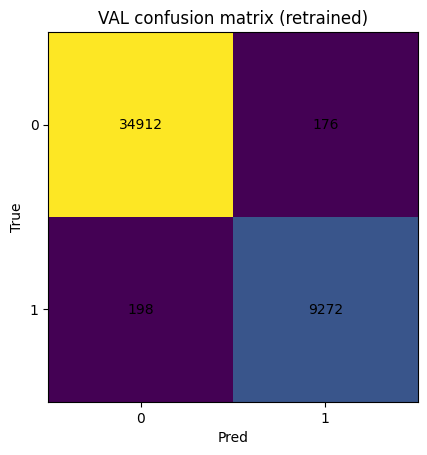

In [12]:
# --- Evaluate retrained best checkpoint (val) + plots ---
retrained = make_model()
retrained.load_state_dict(torch.load(cfg.retrain_ckpt_out, map_location=device))
retrained.eval()

crit = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
val2 = eval_epoch(retrained, val_loader, crit)

print("VAL (retrained best-by-val-loss):")
for k in ["loss", "token_acc", "precision_1", "recall_1", "f1_1"]:
    print(f"  {k}: {val2[k]:.6f}")

plot_confusion_matrix(val2["confusion"], title="VAL confusion matrix (retrained)")

# Overfitting hint:
# - If train_loss keeps going down but val_loss starts rising -> overfitting.
# - If both go down together -> generalizing (good).


In [13]:
# --- Optional qualitative check: decode a few samples ---
# We'll pick a few random validation samples, run inference, and print output.
# NOTE: We don't have the gold segmented sentence stored directly (only boundary labels),
# so this prints predicted segmentation only.

def predict_segment(model: nn.Module, text: str, vocab: Dict[str,int]) -> str:
    model.eval()
    unk = vocab.get("<UNK>", 1)
    chunks = [text[i:i+cfg.max_length] for i in range(0, len(text), cfg.max_length)]
    outs = []
    with torch.no_grad():
        for ch in chunks:
            ids = [vocab.get(c, unk) for c in ch]
            x = torch.tensor(ids, dtype=torch.long).unsqueeze(0).to(device)
            logits = model(x)
            pred = logits.argmax(dim=-1).squeeze(0).tolist()
            outs.append(decode_spaces(ch, pred))
    return "".join(outs)

# Show samples
k = 5
indices = rng.choice(len(val_texts), size=min(k, len(val_texts)), replace=False)
for i in indices:
    raw = val_texts[i]
    pred = predict_segment(retrained, raw, vocab)
    print("="*80)
    print("RAW:", raw[:200], "..." if len(raw) > 200 else "")
    print("PRED:", pred[:200], "..." if len(pred) > 200 else "")


RAW: ក្រុមហ៊ុនផ្តល់សេវាអ៊ីធើណេតEZECOMបានជូនដំណឹងនៅលើFacebookផ្លូវការរបស់ខ្លួនយ៉ាងដូច្នេះថា«យើងខ្ញុំមានទុក្ខយ៉ាងក្រៀមក្រំដោយលោកអគ្គនាយកក្រុមហ៊ុនEZECOMឧកញ៉ាផូលប្លែនហ័រហ្គែនបានទទួលមរណភាពកាលពីព្រឹកថ្ងៃទី២៦កក្ក ...
PRED: ក្រុមហ៊ុន ផ្តល់ សេវា អ៊ីធើណេត EZECOM បាន ជូនដំណឹង នៅលើ Facebook ផ្លូវការ របស់ ខ្លួន យ៉ាង ដូច្នេះ ថា « យើងខ្ញុំ មាន ទុក្ខ យ៉ាង ក្រៀមក្រំ ដោយ លោក អគ្គ នាយកក្រុមហ៊ុន EZECOM ឧកញ៉ា ផូល ប្លែន ហ័រហ្គែន បាន ទ ...
RAW: (ភ្នំពេញ)៖ដុតកម្ទេចសំណល់វេជ្ជសាស្ត្រដែលជាស្នាដៃរបស់កូនខ្មែរត្រូវសម្ពោធដាក់ឱ្យដំណើរការនៅអង្គភាពគ្រប់គ្រងសេវាកម្មសំណល់វេជ្ជសាស្ត្រដើម្បីជួយកាត់បន្ថយផលប៉ះពាល់បរិស្ថានរាជធានីភ្នំពេញស្ថិតនៅទីលានសំណល់វេជ្ជស ...
PRED: ( ភ្នំពេញ ) ៖ ដុត កម្ទេច សំណល់ វេជ្ជសាស្ត្រ ដែល ជា ស្នាដៃ របស់ កូន ខ្មែរ ត្រូវ សម្ពោធ ដាក់ ឱ្យ ដំណើរការ នៅ អង្គភាព គ្រប់គ្រង សេវាកម្ម សំណល់ វេជ្ជសាស្ត្រដើម្បី ជួយ កាត់បន្ថយ ផលប៉ះពាល់ បរិស្ថាន រាជធានី  ...
RAW: ម្យ៉ាងវិញទៀតបើតាមផ្លូវការArea51ត្រូវរដ្ឋាភិបាលអាមេរិកហៅថា«ទីតាំងធ្វើតេស្តនិងហ្វឹកហ្វឺនNevada»ខណៈគោលដៅចម្បងពិតប្រាកដរបស់វាគឺមិនត្រូវបានដឹងជាសាធារណៈឡើយដែលម